In [259]:
import numpy as np
import pandas as pd
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('classic')

raw_data = pd.read_csv('../input/traffic-collision-data-from-2010-to-present.csv')
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 474200 entries, 0 to 474199
Data columns (total 24 columns):
DR Number                            474200 non-null int64
Date Reported                        474200 non-null object
Date Occurred                        474200 non-null object
Time Occurred                        474200 non-null int64
Area ID                              474200 non-null int64
Area Name                            474200 non-null object
Reporting District                   474200 non-null int64
Crime Code                           474200 non-null int64
Crime Code Description               474200 non-null object
MO Codes                             389429 non-null object
Victim Age                           396866 non-null float64
Victim Sex                           467308 non-null object
Victim Descent                       466608 non-null object
Premise Code                         474175 non-null float64
Premise Description                  474175 non-null

In [260]:
raw_data.head(5)

,DR Number,Date Reported,Date Occurred,Time Occurred,Area ID,Area Name,Reporting District,Crime Code,Crime Code Description,MO Codes,Victim Age,Victim Sex,Victim Descent,Premise Code,Premise Description,Address,Cross Street,Location,Zip Codes,Census Tracts,Precinct Boundaries,LA Specific Plans,Council Districts,Neighborhood Councils (Certified)
0,191609699,2019-06-01T00:00:00.000,2019-06-01T00:00:00.000,1230,16,Foothill,1645,997,TRAFFIC COLLISION,NaN,99.0,M,O,101.0,STREET,PIERCE ST,NORRIS AV,"{'latitude': '34.2674', 'longitude': '-118.413...",18907.0,33.0,1370.0,NaN,1.0,11.0
1,190911647,2019-06-01T00:00:00.000,2019-06-01T00:00:00.000,550,9,Van Nuys,991,997,TRAFFIC COLLISION,NaN,35.0,F,W,101.0,STREET,MULHOLLAND,WOODCLIFF,"{'latitude': '34.1305', 'longitude': '-118.461...",24037.0,340.0,672.0,46.0,7.0,83.0
2,190410505,2019-06-01T00:00:00.000,2019-06-01T00:00:00.000,340,4,Hollenbeck,412,997,TRAFFIC COLLISION,0605,NaN,X,X,101.0,STREET,AVENUE 26,DALY,"{'latitude': '34.0784', 'longitude': '-118.217...",23448.0,485.0,648.0,NaN,11.0,1.0
3,190911638,2019-06-01T00:00:00.000,2019-06-01T00:00:00.000,25,9,Van Nuys,952,997,TRAFFIC COLLISION,NaN,32.0,M,W,101.0,STREET,MAGNOLIA BL,SEPULVEDA BL,"{'latitude': '34.1649', 'longitude': '-118.466...",19735.0,246.0,649.0,NaN,7.0,83.0
4,190911644,2019-06-01T00:00:00.000,2019-06-01T00:00:00.000,520,9,Van Nuys,914,997,TRAFFIC COLLISION,4009,18.0,M,H,101.0,STREET,SHERMAN CI,GAULT ST,"{'latitude': '34.1994', 'longitude': '-118.450...",19733.0,229.0,288.0,NaN,3.0,18.0


In [261]:
# get most and least common occuring items per field, up to 5
for column in raw_data.columns:
    uniques = raw_data[column].value_counts()
    print("{}\n{} distincts: {}".format(column, pd.concat([uniques.head(5), uniques.tail(5)]), len(uniques)))

DR Number
171221387    2
151120277    2
160305866    2
140518225    2
190309531    2
180314299    1
141514940    1
141510846    1
171917503    1
140511233    1
Name: DR Number, dtype: int64 distincts: 473328
Date Reported
2018-04-12T00:00:00.000    235
2017-11-17T00:00:00.000    212
2018-10-01T00:00:00.000    209
2017-12-15T00:00:00.000    209
2017-09-08T00:00:00.000    206
2010-01-07T00:00:00.000     74
2010-12-25T00:00:00.000     73
2011-12-28T00:00:00.000     73
2013-01-28T00:00:00.000     64
2019-06-01T00:00:00.000     39
Name: Date Reported, dtype: int64 distincts: 3439
Date Occurred
2017-11-17T00:00:00.000    230
2016-12-15T00:00:00.000    223
2017-12-01T00:00:00.000    219
2010-12-17T00:00:00.000    219
2016-02-17T00:00:00.000    218
2015-01-19T00:00:00.000     79
2010-11-25T00:00:00.000     73
2013-11-28T00:00:00.000     71
2012-12-25T00:00:00.000     68
2019-06-01T00:00:00.000     21
Name: Date Occurred, dtype: int64 distincts: 3439
Time Occurred
1800    6586
1700    6247
1600

In [266]:
# Create some features
time_labels = list(map(str, list(np.arange(0, 2400, 100))))
raw_data['Time Binned'] = pd.cut(raw_data['Time Occurred'], bins = 24, labels = time_labels)
raw_data['Reported Day'] = pd.to_datetime(raw_data['Date Reported']).dt.weekday
raw_data['Occurred Day'] = pd.to_datetime(raw_data['Date Occurred']).dt.weekday

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<BarContainer object of 24 artists>

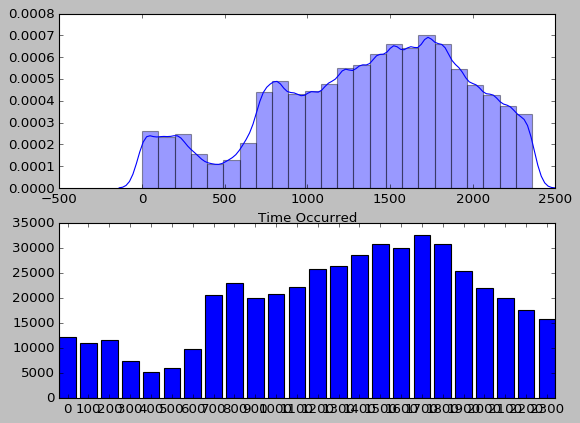

In [269]:
# Take a look at timing of collisions, most occur after work with spike in mornings
plt.subplot(2, 1, 1)
sns.distplot(raw_data['Time Occurred'], bins=24)
v = raw_data['Time Binned'].value_counts(sort=False)
plt.subplot(2, 1, 2)
plt.bar(v.index, v.values)

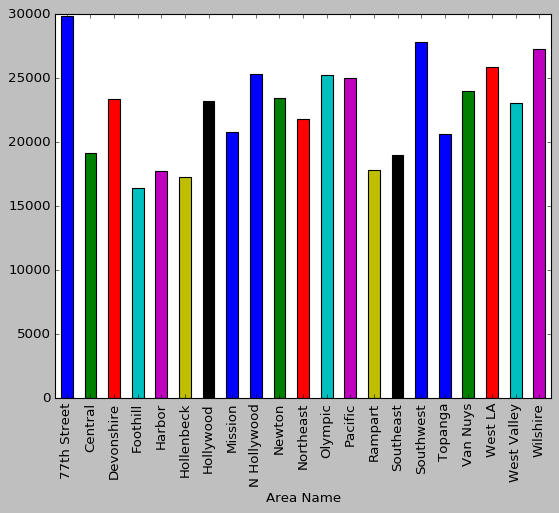

In [273]:
# Area of collisions. Some areas 2x others.
raw_data.groupby('Area Name')['DR Number'].count().plot(kind='bar')

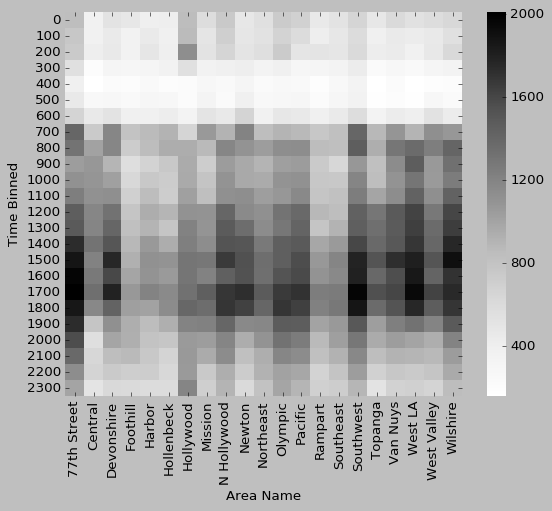

In [274]:
# heatmap of Area VS Time. Hollywood has a lot of accidents at night!
a_x_t = raw_data.pivot_table('DR Number', index='Time Binned', columns='Area Name', aggfunc='count')
sns.heatmap(a_x_t, cmap='Greys')

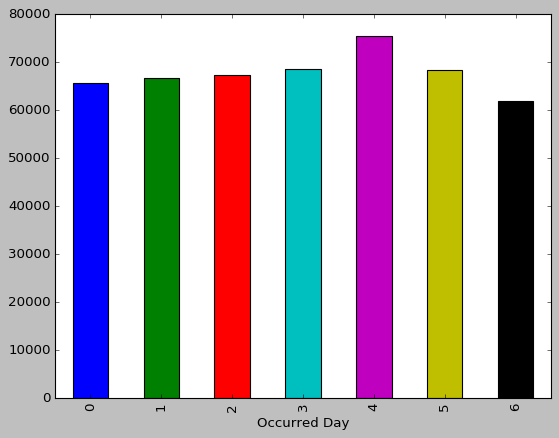

In [275]:
# Days of the week accidents occur on. Spike on Fridays.
raw_data.groupby('Occurred Day')['DR Number'].count().plot(kind='bar')

   Occurred Day  Reported Day
0         65603         68327
1         66793         68132
2         67352         68095
3         68574         68962
4         75426         70968
5         68486         66961
6         61966         62755


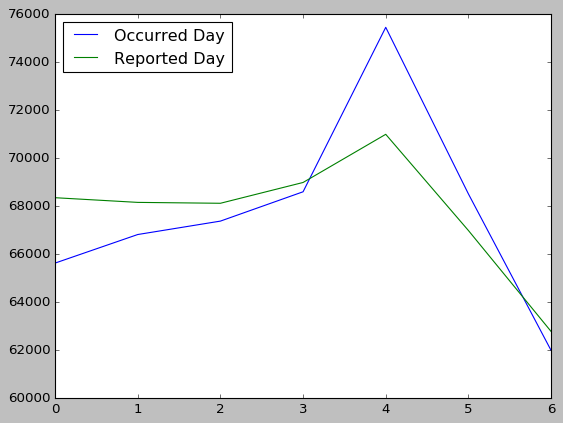

In [276]:
# There's a descrepancy between Occured day and Reported day, namely a lot of accidents happen on Friday and get reported later.
occurred_day = raw_data.groupby('Occurred Day')['DR Number'].count()
reported_day = raw_data.groupby('Reported Day')['DR Number'].count()
occurred_day.name = 'Occurred Day'
reported_day.name = 'Reported Day'
combined = pd.concat([occurred_day, reported_day], axis=1)
print(combined)
combined.plot()

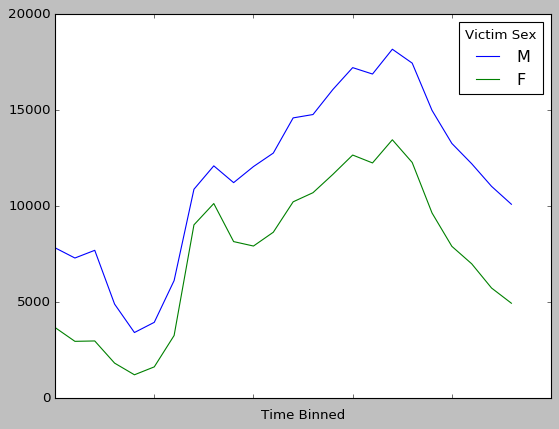

In [282]:
# Males vs Female Accidents throughout the day. Note that there may just be more males on the roads then females. Or could it be that females are better drivers, except when going to work?
m_f = raw_data.pivot_table('DR Number', index='Time Binned', columns='Victim Sex', aggfunc='count')
m_f = m_f[['M', 'F']]
m_f.plot()

/opt/conda/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


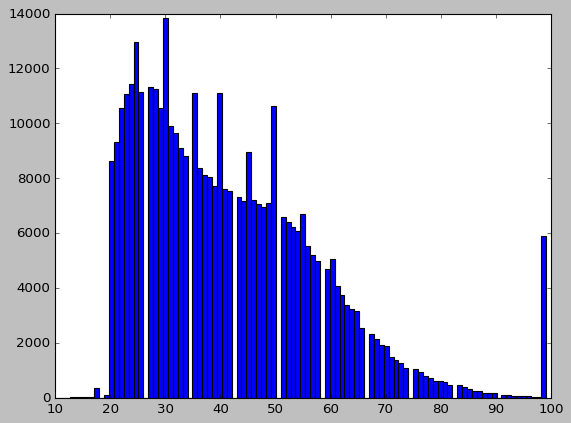

In [287]:
# Collisions by age. Note the spike at 99. Maybe the LAPD has some rule where undetermined ages get thrown into 99?
plt.hist(raw_data['Victim Age'], bins=100)
pass